In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import pandas as pd
from math import *
import seaborn as sns
from sklearn.cluster import DBSCAN
#from mpl_toolkits.basemap import Basemap
import pickle

In [3]:
pd.__version__

u'0.23.1'

### Malpractice Data:

In [4]:
data = pd.read_csv('NpdbPublicUseDataCsv/NPDB1710.CSV',delimiter=',',low_memory=False)

In [5]:
## Clean the payment column so it's numeric:
data["PAYMENT"].replace('[\$,]', '', regex=True, inplace=True)

In [6]:
data["TOTALPMT"].replace('[\$,]', '', regex=True, inplace=True)

In [7]:
data["FUNDPYMT"].replace('[\$,]', '', regex=True, inplace=True)

In [8]:
type(data["ORIGYEAR"][0])

numpy.int64

In [9]:
data.columns

Index([u'SEQNO', u'RECTYPE', u'REPTYPE', u'ORIGYEAR', u'WORKSTAT', u'WORKCTRY',
       u'HOMESTAT', u'HOMECTRY', u'LICNSTAT', u'LICNFELD', u'PRACTAGE',
       u'GRAD', u'ALGNNATR', u'ALEGATN1', u'ALEGATN2', u'OUTCOME', u'MALYEAR1',
       u'MALYEAR2', u'PAYMENT', u'TOTALPMT', u'PAYNUMBR', u'NUMBPRSN',
       u'PAYTYPE', u'PYRRLTNS', u'PTAGE', u'PTGENDER', u'PTTYPE', u'AAYEAR',
       u'AACLASS1', u'AACLASS2', u'AACLASS3', u'AACLASS4', u'AACLASS5',
       u'BASISCD1', u'BASISCD2', u'BASISCD3', u'BASISCD4', u'BASISCD5',
       u'AALENTYP', u'AALENGTH', u'AAEFYEAR', u'AASIGYR', u'TYPE', u'PRACTNUM',
       u'ACCRRPTS', u'NPMALRPT', u'NPLICRPT', u'NPCLPRPT', u'NPPSMRPT',
       u'NPDEARPT', u'NPEXCRPT', u'NPGARPT', u'NPCTMRPT', u'FUNDPYMT'],
      dtype='object')

In [10]:
data

,SEQNO,RECTYPE,REPTYPE,ORIGYEAR,WORKSTAT,WORKCTRY,HOMESTAT,HOMECTRY,LICNSTAT,LICNFELD,...,ACCRRPTS,NPMALRPT,NPLICRPT,NPCLPRPT,NPPSMRPT,NPDEARPT,NPEXCRPT,NPGARPT,NPCTMRPT,FUNDPYMT
0,1,A,301,1991,OK,NaN,NaN,NaN,OK,10,...,0,0,2,0,0,0,0,0,0,NaN
1,2,A,301,1991,OK,NaN,NaN,NaN,OK,10,...,0,0,7,0,0,0,1,0,0,NaN
2,4,A,301,1991,MA,NaN,NaN,NaN,MA,15,...,0,1,1,0,0,0,2,0,0,NaN
3,6,A,301,1990,OK,NaN,NaN,NaN,OK,10,...,0,0,2,0,0,0,0,0,0,NaN
4,8,A,301,1990,OK,NaN,NaN,NaN,OK,10,...,0,0,6,0,1,0,0,0,0,NaN
5,9,A,301,1990,OK,NaN,OK,NaN,OK,10,...,0,1,3,0,0,0,0,0,0,NaN
6,12,A,301,1990,VA,NaN,IL,NaN,VA,10,...,0,0,10,0,0,0,0,0,0,NaN
7,13,A,301,1990,KY,NaN,KY,NaN,DC,10,...,0,0,1,0,0,0,0,0,0,NaN
8,14,A,301,1990,OH,NaN,NaN,NaN,OH,30,...,0,0,1,0,0,0,0,0,0,NaN
9,15,A,301,1990,OH,NaN,NaN,NaN,OH,30,...,0,0,3,0,0,0,0,0,0,NaN


### Census/States Data:

In [11]:
#state_pop = pd.read_excel('nst-est2016-01.xlsx',header=3,skip_footer=5)
col_dtype = {'Census': str, 
             'Estimates Base': str, 
             '2010': int,
             '2011': int,
             '2012': int,
             '2013': int,
             '2014': int,
             '2015': int,
             '2016': int,
             'State Abb': str,
            }
state_pop = pd.read_csv('nst-est2016-01.csv',delimiter=',',header=3,skipfooter=5,index_col=0) #,dtype=col_dtype)

new_index_list = {}
for s_label in state_pop.index:
    try:
        if s_label[0]=='.':
            new_index_list.update({s_label: s_label[1:]})
        else:
            new_index_list.update({s_label: s_label})
    except:
        new_index_list.update({s_label: 'unknown'})

state_pop.rename(index=new_index_list,inplace=True)

/home/derya/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.


In [12]:
new_index_list

{'.Alabama': 'Alabama',
 '.Alaska': 'Alaska',
 '.Arizona': 'Arizona',
 '.Arkansas': 'Arkansas',
 '.California': 'California',
 '.Colorado': 'Colorado',
 '.Connecticut': 'Connecticut',
 '.Delaware': 'Delaware',
 '.District of Columbia': 'District of Columbia',
 '.Florida': 'Florida',
 '.Georgia': 'Georgia',
 '.Hawaii': 'Hawaii',
 '.Idaho': 'Idaho',
 '.Illinois': 'Illinois',
 '.Indiana': 'Indiana',
 '.Iowa': 'Iowa',
 '.Kansas': 'Kansas',
 '.Kentucky': 'Kentucky',
 '.Louisiana': 'Louisiana',
 '.Maine': 'Maine',
 '.Maryland': 'Maryland',
 '.Massachusetts': 'Massachusetts',
 '.Michigan': 'Michigan',
 '.Minnesota': 'Minnesota',
 '.Mississippi': 'Mississippi',
 '.Missouri': 'Missouri',
 '.Montana': 'Montana',
 '.Nebraska': 'Nebraska',
 '.Nevada': 'Nevada',
 '.New Hampshire': 'New Hampshire',
 '.New Jersey': 'New Jersey',
 '.New Mexico': 'New Mexico',
 '.New York': 'New York',
 '.North Carolina': 'North Carolina',
 '.North Dakota': 'North Dakota',
 '.Ohio': 'Ohio',
 '.Oklahoma': 'Oklahoma',
 '

In [13]:
state_pop

,Census,Estimates Base,2010,2011,2012,2013,2014,2015,2016,State Abb
United States,"308,745,538","308,758,105","309,348,193","311,663,358","313,998,379","316,204,908","318,563,456","320,896,618","323,127,513",US
Northeast,"55,317,240","55,318,353","55,388,056","55,632,766","55,829,059","55,988,771","56,116,791","56,184,737","56,209,510",NE
Midwest,"66,927,001","66,929,825","66,978,602","67,153,331","67,332,320","67,543,948","67,726,368","67,838,387","67,941,429",MW
South,"114,555,744","114,563,005","114,863,114","116,061,801","117,299,171","118,424,320","119,696,311","121,039,206","122,319,574",SO
West,"71,945,553","71,946,922","72,118,421","72,815,460","73,537,829","74,247,869","75,023,986","75,834,288","76,657,000",WE
Alabama,"4,779,736","4,780,131","4,785,492","4,799,918","4,815,960","4,829,479","4,843,214","4,853,875","4,863,300",AL
Alaska,"710,231","710,249","714,031","722,713","731,089","736,879","736,705","737,709","741,894",AK
Arizona,"6,392,017","6,392,301","6,408,312","6,467,163","6,549,634","6,624,617","6,719,993","6,817,565","6,931,071",AZ
Arkansas,"2,915,918","2,916,025","2,921,995","2,939,493","2,950,685","2,958,663","2,966,912","2,977,853","2,988,248",AR
California,"37,253,956","37,254,522","37,332,685","37,676,861","38,011,074","38,335,203","38,680,810","38,993,940","39,250,017",CA


In [14]:
for i in range(2010,2017):
    state_pop[str(i)] = state_pop[str(i)].transform(lambda x: int(''.join(x.strip().split(',')) ))

In [15]:
state_pop['Census'] = state_pop['Census'].transform(lambda x: int(''.join(x.strip().split(',')) ))
state_pop['Estimates Base'] = state_pop['Estimates Base'].transform(lambda x: int(''.join(x.strip().split(',')) ))

In [16]:
state_pop

,Census,Estimates Base,2010,2011,2012,2013,2014,2015,2016,State Abb
United States,308745538,308758105,309348193,311663358,313998379,316204908,318563456,320896618,323127513,US
Northeast,55317240,55318353,55388056,55632766,55829059,55988771,56116791,56184737,56209510,NE
Midwest,66927001,66929825,66978602,67153331,67332320,67543948,67726368,67838387,67941429,MW
South,114555744,114563005,114863114,116061801,117299171,118424320,119696311,121039206,122319574,SO
West,71945553,71946922,72118421,72815460,73537829,74247869,75023986,75834288,76657000,WE
Alabama,4779736,4780131,4785492,4799918,4815960,4829479,4843214,4853875,4863300,AL
Alaska,710231,710249,714031,722713,731089,736879,736705,737709,741894,AK
Arizona,6392017,6392301,6408312,6467163,6549634,6624617,6719993,6817565,6931071,AZ
Arkansas,2915918,2916025,2921995,2939493,2950685,2958663,2966912,2977853,2988248,AR
California,37253956,37254522,37332685,37676861,38011074,38335203,38680810,38993940,39250017,CA


### Some preliminary analysis:

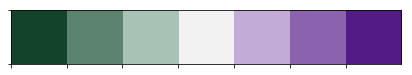

In [17]:
#sns.set_style("ticks")
current_palette = sns.diverging_palette(145, 280, s=85, l=25, n=7) #sns.color_palette()
current_palette[0]
sns.palplot(current_palette)
plt.show()

In [18]:
years = range(1990,2018)
counts = [len(data[data['ORIGYEAR']==year]) for year in range(1990,2018)]
payments = [pd.to_numeric(data[data['ORIGYEAR']==year]['PAYMENT']).mean(skipna=True) for year in range(1990,2018)]

In [19]:
pickle.dump(years, open("years.pck", "wb"))
pickle.dump(counts, open("counts.pck", "wb"))
pickle.dump(payments, open("payments.pck", "wb"))

In [20]:
import bokeh
bokeh.__version__

u'0.12.16'

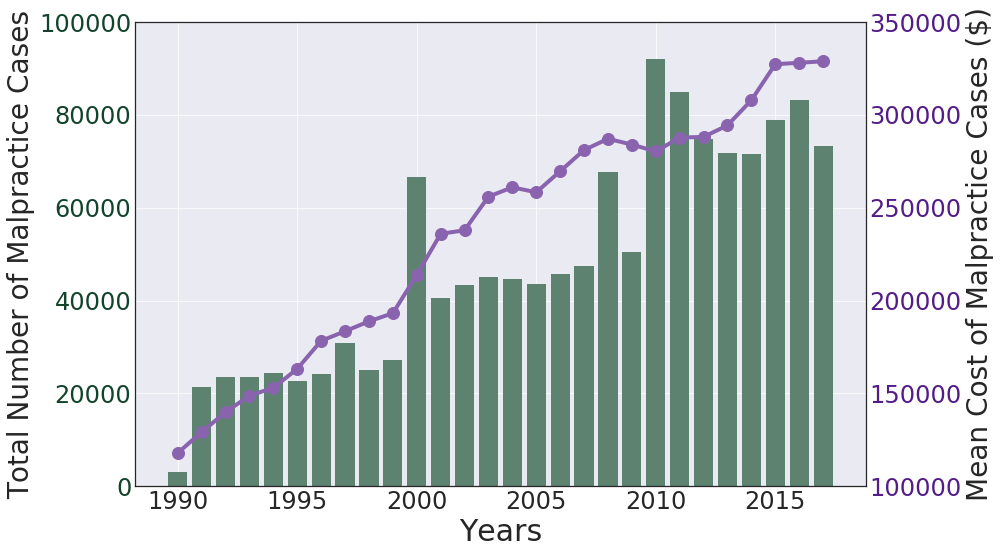

In [21]:
sns.set_style("darkgrid")

fig, ax1 = plt.subplots(figsize=(14,8))

ax1.bar(years,counts,color=current_palette[1])
ax1.set_xlabel('Years',fontsize=30)
ax1.tick_params(axis='x',labelsize=24)
ax1.set_ylabel('Total Number of Malpractice Cases',fontsize=28)
ax1.tick_params(axis='y',labelsize=24,labelcolor=current_palette[0])
ax1.set_ylim(0,100000)



sns.set_style("white")
ax2 = ax1.twinx()
ax2.plot(years,payments,
         color=current_palette[5],marker='o',markersize=12,linewidth=4)
ax2.set_ylabel('Mean Cost of Malpractice Cases ($)',fontsize=28)
ax2.tick_params(axis='y',labelsize=24,labelcolor=current_palette[6])
ax2.set_ylim(100000,350000)


fig.tight_layout()
#sns.despine()

plt.savefig('total_numbers_costs_across_us.jpg',dpi=100)
plt.show()

sns.set_style("darkgrid")

fig, ax1 = plt.subplots(figsize=(14,8))

ax1.bar(range(1990,2018),[len(data[data['ORIGYEAR']==year]) for year in range(1990,2018)],color=current_palette[1])
ax1.set_xlabel('Years',fontsize=30)
ax1.tick_params(axis='x',labelsize=24)
ax1.set_ylabel('Total Number of Malpractice Cases',fontsize=28)
ax1.tick_params(axis='y',labelsize=24,labelcolor=current_palette[0])
ax1.set_ylim(0,100000)



sns.set_style("white")
ax2 = ax1.twinx()
color = 'tab:red'
ax2.plot(range(1990,2018),
        [pd.to_numeric(data[data['ORIGYEAR']==year]['PAYMENT']).mean(skipna=True) for year in range(1990,2018)],
         color=current_palette[5],marker='o',markersize=12,linewidth=4)
ax2.set_ylabel('Mean Cost of Malpractice Cases ($)',fontsize=28)
ax2.tick_params(axis='y',labelsize=24,labelcolor=current_palette[6])
ax2.set_ylim(100000,350000)


fig.tight_layout()
#sns.despine()

plt.savefig('total_numbers_costs_across_us.jpg',dpi=100)
plt.show()

plt.bar(range(1990,2018),
        [pd.to_numeric(data[data['ORIGYEAR']==year]['FUNDPYMT']).mean(skipna=True) for year in range(1990,2018)],
        yerr=[pd.to_numeric(data[data['ORIGYEAR']==year]['FUNDPYMT']).sem(skipna=True) for year in range(1990,2018)])
plt.xlabel('Years')
plt.ylabel('State Payments for Malpractice Cases Across the US')
plt.tight_layout()
plt.savefig('fund_pymt_across_us.png',dpi=300)
plt.show()

data.hist(column='ORIGYEAR',bins=2018-1990,range=(1990,2018),alpha=0.5,by='WORKSTAT',figsize=(20,40),layout=(13,5))
plt.xlabel('Years')
plt.ylabel('Total Cases')
plt.tight_layout()
plt.savefig('total_per_state.png',dpi=300)
plt.show()

### Find states common to census data and malpractice data:

In [22]:
common_states = np.intersect1d(list(data["WORKSTAT"].unique()),list(state_pop["State Abb"]))

In [23]:
print(common_states,len(common_states))

(array(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
       'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
       'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
       'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN',
       'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'],
      dtype='|S3'), 52)


In [24]:
print(state_pop[state_pop["State Abb"]=="CA"]["2016"][0])
print(state_pop[state_pop["State Abb"]=="NY"]["2016"][0])
print(state_pop[state_pop["State Abb"]=="PA"]["2016"][0])

39250017
19745289
12784227


### We start clustering analysis for the common_states in the data:

In [25]:
pay_count = None
for state in common_states:
    #print(state)
    arrays = [[state,state], ['pay_per_case', 'count_per_1000000']]
    column_names = pd.MultiIndex.from_arrays(arrays).T
    mean_payment = [pd.to_numeric(data[(data["WORKSTAT"]==state) & (data["ORIGYEAR"]==i)]['PAYMENT']).mean() for i in range(1990,2018)]
    count_per_capita = [1000000.0*len(data[(data["WORKSTAT"]==state) & (data["ORIGYEAR"]==i)])/state_pop[state_pop["State Abb"]==state]["2016"][0] for i in range(1990,2018)]
    stack = pd.DataFrame(np.stack((mean_payment,
                                   count_per_capita),axis=0).T,
                         columns=column_names,
                         index=range(1990,2018))
    #print(stack)
    if type(pay_count)==None:
        pay_count = stack
    else:
        pay_count = pd.concat([pay_count, stack], axis=1)

In [26]:
pay_count

AK                               AL                    \
       pay_per_case count_per_1000000   pay_per_case count_per_1000000   
1990            NaN          1.347901  166966.666667          4.112434   
1991  196140.625000         41.784945  121558.333333         23.646495   
1992  105808.333333         59.307664  217455.555556         23.440873   
1993  130986.764706         67.395073  230903.448276         26.525199   
1994   85071.428571         59.307664  254741.666667         24.468982   
1995  178137.500000         43.132846  281157.894737         25.497090   
1996  151242.857143         52.568157  405196.236559         25.291469   
1997  158375.000000         36.393339  225808.988764         28.581416   
1998  286718.750000         52.568157  296460.674157         31.871363   
1999  270546.296296         94.353102  274947.887324         30.637633   
2000  159310.344828        172.531386  367873.529412        330.434067   
2001  240925.000000         48.524452  244472.727273        116.998746   
2002  210240.384615         40.437044  233686.781609        137.355294   
2003  241908.333333         57.959762  212584.027778        137.766537   
2004  189822.000000         47.176551  211181.818182        154.421895   
2005  737932.692308         48.524452  223898.305085        163.058006   
2006  187931.818182         44.480748  281934.375000        179.096498   
2007  482916.666667         33.697536  182864.912281        179.918985   
2008  193289.473684         44.480748  310454.545455         67.443917   
2009  229140.625000         40.437044  306960.000000         42.152448   
2010  615511.904762         51.220255  282437.500000        204.593589   
2011  419333.333333         53.916058  250020.833333        190.611313   
2012  361029.411765         49.872354  317812.500000         82.043057   
2013  289482.142857         62.003467  454377.659574         45.236773   
2014  270666.666667         78.178284  637780.172414         41.124339   
2015  334264.705882         60.655565  308533.653846         53.256020   
2016  208750.000000         47.176551  426599.000000         49.966072   
2017  251363.636364         62.003467  402366.071429         56.957210   

                 AR                               AZ                    \
       pay_per_case count_per_1000000   pay_per_case count_per_1000000   
1990   81357.142857          6.023596  166171.250000          6.203947   
1991   83832.258065         39.488021  122601.452282         47.178856   
1992  226307.065217         39.822665  181994.117647         58.143972   
1993  126375.000000         37.145511  111253.600000         57.134027   
1994  116544.871795         32.795136  155957.993197         64.347920   
1995  107418.354430         35.806934  183279.904306         61.029529   
1996  105860.000000         36.476223  134880.930931         79.352816   
1997   96891.791045         35.472290  230950.825083         67.233477   
1998  178015.789474         49.861993  164200.390625         54.248470   
1999  187451.219512         41.495887  182063.586957         69.253366   
2000  225487.654321         80.314619  231539.655172        138.651011   
2001  169092.233010         67.263494  257575.301205        104.745717   
2002  226741.818182         65.590272  254643.769968        102.870105   
2003  326037.974684         71.948513  274889.041096        107.486996   
2004  261940.229885         38.484088  291361.991870        102.148716   
2005  295718.085106         37.480156  273618.580060         91.327877   
2006  213264.492754         33.464425  253462.264151        147.884793   
2007  259293.103448         31.456559  313289.676113        100.994493   
2008  319433.035714         29.448694  327817.073171        104.889995   
2009  330504.098361         36.476223  295964.508929         95.656212   
2010  291380.434783         32.125848  263381.909548         97.387547   
2011  304291.666667         53.208435  311558.849558        114.556610   
2012  252745.833333 

In [27]:
state_slope = []
for state in common_states:
    slope, intercept, rvalue, pvalue, stderr = scipy.stats.linregress(range(1991,2018),
                                                                      pay_count[state,"count_per_1000000"][1:])
    state_slope.append([state,slope,intercept])
    
df_state_slope=pd.DataFrame(state_slope,columns=["state","slope","intercept"])
#df_state_slope #.sort_values("slope")

In [28]:
correlation_slope = np.zeros((len(common_states),len(common_states)))

for state1 in range(len(common_states)):
    for state2 in range(len(common_states)):
        #print(float(df_state_slope[df_state_slope["state"]==common_states[state1]]["slope"]))
        #print(float(df_state_slope[df_state_slope["state"]==common_states[state2]]["slope"]))
        #correlation_slope[state1,state2] = np.sqrt(((
        #    float(df_state_slope[df_state_slope["state"]==common_states[state1]]["slope"])-
        #    float(df_state_slope[df_state_slope["state"]==common_states[state2]]["slope"])))**2)
        correlation_slope[state1,state2] = ((
            float(df_state_slope[df_state_slope["state"]==common_states[state1]]["slope"])-
            float(df_state_slope[df_state_slope["state"]==common_states[state2]]["slope"])))**2

In [29]:
#print(correlation_slope)

In [30]:
from sklearn.cluster import DBSCAN
# Compute DBSCAN

db = DBSCAN(eps=0.05, min_samples=1,metric='precomputed').fit_predict(correlation_slope)
#core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
#core_samples_mask[db.core_sample_indices_] = True
#for i in np.unique(db):
#    print(i,common_states[np.where(db==i)])
    
df_state_cluster = pd.DataFrame(db.T,columns=["cluster"])
df_state_slope_cluster = pd.concat([df_state_slope,df_state_cluster],axis=1)

average_slopes = []
for state in common_states:
    current_cluster = int(df_state_slope_cluster[df_state_slope_cluster["state"]==state]["cluster"])
    #print(current_cluster)
    average_slope = df_state_slope_cluster[df_state_slope_cluster["cluster"]==current_cluster]["slope"].mean()
    average_slopes.append(average_slope)
    
df_cluster_slope = pd.DataFrame(np.array(average_slopes).T,columns=["avg_slopes"])
df_state_slope_cluster_aslope = pd.concat([df_state_slope_cluster,df_cluster_slope],axis=1)

cluster_colors = pd.DataFrame(np.array(average_slopes).T,columns=["cl_colors"])
df_state_slope_cluster_aslope_acolor = pd.concat([df_state_slope_cluster_aslope,cluster_colors],axis=1)

start = 0
for i in np.unique(df_state_slope_cluster_aslope["avg_slopes"].sort_values()):
    #print(i)
    #print(start)
    df_state_slope_cluster_aslope_acolor.replace(to_replace= {'cl_colors': {i: start}}, inplace=True)
    start += 1

In [31]:
#df_state_slope_cluster_aslope_acolor

for i in range(len(np.unique(db))):
    print("CLUSTER "+str(i))
    data[data["WORKSTAT"].isin(list(common_states[np.where(db==i)]))].hist(column='ORIGYEAR',bins=2018-1990,range=(1990,2018),alpha=0.5,by='WORKSTAT',figsize=(20,60),layout=(20,3))
    plt.show()

In [32]:
from bokeh.io import show, save, output_notebook #, export_png
from bokeh.models import (
    ColumnDataSource,
    HoverTool,
    ContinuousColorMapper,
    LabelSet,
    Label,
    LogColorMapper, 
    LogTicker, 
    FixedTicker,
    ColorBar, 
    LinearColorMapper,
    Legend
)
from bokeh.plotting import figure, output_file, show
## This is where we get the state data from:
from bokeh.sampledata.us_states import data as states
from bokeh.resources import CDN
from bokeh.embed import file_html
from bokeh.palettes import PRGn11 as palette
from bokeh.palettes import Category20,Spectral11,Category10,PRGn11

In [33]:
try:
    del states["HI"]
    del states["AK"]
except:
    pass

#palette.reverse()

states = {
    code: state for code, state in states.items()
}
#print(states)

state_xs = [states[code]["lons"] for code in states]
state_ys = [states[code]["lats"] for code in states]
state_names = [state['name'] for state in states.values()]

state_rates = []
for name in state_names:
    abbr = state_pop.loc[name]["State Abb"]
    state_rates.append(float(df_state_slope[df_state_slope["state"]==abbr]["slope"]))
    
state_abbr = []
for name in state_names:
    abbr = state_pop.loc[name]["State Abb"]
    state_abbr.append(abbr)
    
#print(state_rates)

lat_inkm = 111.132 ## at around lat = 45degrees from the wiki latitude page
lon_inkm = 78.847 ## at around lat = 45degrees from the wiki latitude page

In [34]:
text_position_x = []
for statex in state_xs:
    text_position_x.append(float("%.5f" % round(max(statex)-(max(statex)-min(statex))/2,5)))
    
text_position_y = []
for statey in state_ys:
    text_position_y.append(float("%.5f" % round(max(statey)-(max(statey)-min(statey))/2,5)))

In [35]:
state_clusters=[]
for name in state_names:
    abbr = state_pop.loc[name]["State Abb"]
    state_clusters.append(palette[int(df_state_slope_cluster_aslope_acolor[df_state_slope_cluster_aslope_acolor["state"]==abbr]["cl_colors"])])

#state_clusters

In [36]:
cluster_label = []
for name in state_names:
    abbr = state_pop.loc[name]["State Abb"]
    cluster_label.append(int(df_state_slope_cluster_aslope_acolor[df_state_slope_cluster_aslope_acolor["state"]==abbr]["cl_colors"])+1)

#cluster_label

In [37]:
import pickle
print(pickle.compatible_formats)

['1.0', '1.1', '1.2', '1.3', '2.0']


In [38]:
#state_xs

In [39]:
pickle.dump(state_xs, open("state_xs.pck", "wb"))
pickle.dump(state_ys, open("state_ys.pck", "wb"))
pickle.dump(state_names, open("state_names.pck", "wb"))
pickle.dump(state_rates, open("state_rates.pck", "wb"))
pickle.dump(state_clusters, open("state_clusters.pck", "wb"))
pickle.dump(cluster_label, open("cluster_label.pck", "wb"))

state_xs = pickle.load(open("state_xs.pck", "rb"))
state_ys = pickle.load(open("state_ys.pck", "rb"))
state_names = pickle.load(open("state_names.pck", "rb"))
state_rates = pickle.load(open("state_rates.pck", "rb"))
state_clusters = pickle.load(open("state_clusters.pck", "rb"))
cluster_label = pickle.load(open("cluster_label.pck", "rb"))

In [40]:
output_notebook()

color_mapper = LinearColorMapper(palette=palette) #, low=min(state_rates), high=max(np.unique(state_rates)))

source = ColumnDataSource(data=dict(
    x=state_xs,
    y=state_ys,
    name=state_names,
    rate=state_rates,
    clusters=state_clusters,
    cluster_label=cluster_label,
))

TOOLS = "pan,wheel_zoom,reset,hover,save"

p = figure(title="Change in the number of malpractice cases filed per a million citizens per states, 1990-2018", 
    plot_width=int((max(max(state_xs))-min(min(state_xs)))*lon_inkm/4.5), 
    plot_height=int((max(max(state_ys))-min(min(state_ys)))*lat_inkm/4.5), tools=TOOLS,
    x_axis_location=None, y_axis_location=None
)

p.grid.grid_line_color = None

p.patches('x', 'y', source=source,
          fill_color='clusters',
          fill_alpha=0.7, line_color="gray", line_width=0.5)

color_bar = ColorBar(color_mapper=color_mapper, #ticker=FixedTicker(ticks=np.unique(cluster_label)),
                     label_standoff=12, border_line_color=None, location=(0,0),major_label_text_font_size="14pt")

p.add_layout(color_bar, 'right')

hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips ="""
    <font size="3">State: <strong>@name</strong> </font> <br>
    <font size="3">Change in the number of   </font> <br>
    <font size="3">malpractice cases: <strong>@rate per 1,000,000</strong> </font> <br>
    <font size="3">Ranking: <strong>@cluster_label</strong> </font>
"""
show(p)

#output_file("malpractice_by_state.html",title="Malpractice by state")
#save(p, filename="malpractice_by_state.html", title="Malpractice by state", resource='cdn')


Loading BokehJS ...

In [41]:
pickle.dump(df_state_slope_cluster_aslope_acolor, open("df_state_slope_cluster_aslope_acolor.pck", "wb"))
pickle.dump(pay_count, open("pay_count.pck", "wb"))

In [42]:
df_state_slope_cluster_aslope_acolor = pickle.load(open("df_state_slope_cluster_aslope_acolor.pck", "rb"))
pay_count = pickle.load(open("pay_count.pck", "rb"))

In [43]:
pay_count

AK                               AL                    \
       pay_per_case count_per_1000000   pay_per_case count_per_1000000   
1990            NaN          1.347901  166966.666667          4.112434   
1991  196140.625000         41.784945  121558.333333         23.646495   
1992  105808.333333         59.307664  217455.555556         23.440873   
1993  130986.764706         67.395073  230903.448276         26.525199   
1994   85071.428571         59.307664  254741.666667         24.468982   
1995  178137.500000         43.132846  281157.894737         25.497090   
1996  151242.857143         52.568157  405196.236559         25.291469   
1997  158375.000000         36.393339  225808.988764         28.581416   
1998  286718.750000         52.568157  296460.674157         31.871363   
1999  270546.296296         94.353102  274947.887324         30.637633   
2000  159310.344828        172.531386  367873.529412        330.434067   
2001  240925.000000         48.524452  244472.727273        116.998746   
2002  210240.384615         40.437044  233686.781609        137.355294   
2003  241908.333333         57.959762  212584.027778        137.766537   
2004  189822.000000         47.176551  211181.818182        154.421895   
2005  737932.692308         48.524452  223898.305085        163.058006   
2006  187931.818182         44.480748  281934.375000        179.096498   
2007  482916.666667         33.697536  182864.912281        179.918985   
2008  193289.473684         44.480748  310454.545455         67.443917   
2009  229140.625000         40.437044  306960.000000         42.152448   
2010  615511.904762         51.220255  282437.500000        204.593589   
2011  419333.333333         53.916058  250020.833333        190.611313   
2012  361029.411765         49.872354  317812.500000         82.043057   
2013  289482.142857         62.003467  454377.659574         45.236773   
2014  270666.666667         78.178284  637780.172414         41.124339   
2015  334264.705882         60.655565  308533.653846         53.256020   
2016  208750.000000         47.176551  426599.000000         49.966072   
2017  251363.636364         62.003467  402366.071429         56.957210   

                 AR                               AZ                    \
       pay_per_case count_per_1000000   pay_per_case count_per_1000000   
1990   81357.142857          6.023596  166171.250000          6.203947   
1991   83832.258065         39.488021  122601.452282         47.178856   
1992  226307.065217         39.822665  181994.117647         58.143972   
1993  126375.000000         37.145511  111253.600000         57.134027   
1994  116544.871795         32.795136  155957.993197         64.347920   
1995  107418.354430         35.806934  183279.904306         61.029529   
1996  105860.000000         36.476223  134880.930931         79.352816   
1997   96891.791045         35.472290  230950.825083         67.233477   
1998  178015.789474         49.861993  164200.390625         54.248470   
1999  187451.219512         41.495887  182063.586957         69.253366   
2000  225487.654321         80.314619  231539.655172        138.651011   
2001  169092.233010         67.263494  257575.301205        104.745717   
2002  226741.818182         65.590272  254643.769968        102.870105   
2003  326037.974684         71.948513  274889.041096        107.486996   
2004  261940.229885         38.484088  291361.991870        102.148716   
2005  295718.085106         37.480156  273618.580060         91.327877   
2006  213264.492754         33.464425  253462.264151        147.884793   
2007  259293.103448         31.456559  313289.676113        100.994493   
2008  319433.035714         29.448694  327817.073171        104.889995   
2009  330504.098361         36.476223  295964.508929         95.656212   
2010  291380.434783         32.125848  263381.909548         97.387547   
2011  304291.666667         53.208435  311558.849558        114.556610   
2012  252745.833333 

In [44]:
def create_plot(state):
    print(state)
    p = figure(plot_width=450, plot_height=450, x_axis_label='Years', y_axis_label='Malpractice cases filed per 1,000,000')
    rank = int(df_state_slope_cluster_aslope_acolor[df_state_slope_cluster_aslope_acolor['state']==state]['cl_colors'])
    cur_states = list(df_state_slope_cluster_aslope_acolor[df_state_slope_cluster_aslope_acolor["cl_colors"]==rank]["state"])
    states_title = str()
    #print(cur_states)
    for x in cur_states:
        states_title = states_title+x+', '
    if len(cur_states)>8:
        sel_states = list(np.random.choice(cur_states,size=8,replace=False))
        sel_states.sort()
        if state in sel_states:
            sel_states.pop(sel_states.index(state))
            cur_states = [state]+sel_states
            print('if',cur_states)
        else:
            cur_states = [state]+sel_states[:7]
            print('else',cur_states)
        states_title = str()
        for x in cur_states:
            states_title = states_title+x+', '
        p.title.text = states_title[:-2]+" among others (Ranking "+str(rank)+")."
    else:
        p.title.text = states_title[:-2]+" (Ranking "+str(rank)+")."
    
    for state_, color in zip(cur_states, Category20[20]):
        curve = pay_count[state_,"count_per_1000000"]
        #plt.plot(range(1990,2018),curve,label=state,marker='.')
        r = p.line(curve.index, curve,line_width=2, color=color, alpha=1.,
                   muted_color=color, muted_alpha=0.2, legend=state_)
        if state_!=state:
            r.muted=True
    p.legend.location = "top_right"
    p.legend.click_policy="mute"
    return(p)

#rank = int(df_state_slope_cluster_aslope_acolor[df_state_slope_cluster_aslope_acolor['state']=='AK']['cl_colors'])
#print(rank)
plot_mini = create_plot("CT")
show(plot_mini)

CT
('if', ['CT', 'AR', 'AZ', 'DE', 'KS', 'MA', 'RI', 'VA'])


In [45]:
alist = ['UT', 'SD', 'RI', 'IN', 'FL', 'CA', 'NJ', 'TN']
alist.sort()
alist[:7]

['CA', 'FL', 'IN', 'NJ', 'RI', 'SD', 'TN']

In [46]:
from bokeh.layouts import column, row
from bokeh.models import CustomJS, ColumnDataSource, Select
from bokeh.plotting import Figure, output_file, show
from bokeh.layouts import column, gridplot

output_file("js_on_change.html")

def create_plot(ranking):
    p = figure(plot_width=450, plot_height=450, x_axis_label='Years', y_axis_label='Malpractice cases filed per 1,000,000')
    cur_states = list(df_state_slope_cluster_aslope_acolor[df_state_slope_cluster_aslope_acolor["cl_colors"]==ranking]["state"])
    states_title = str()
    for x in cur_states:
        states_title = states_title+x+', '
    
    if len(cur_states)>8:
        cur_states = np.random.choice(cur_states,size=8,replace=False)
        states_title = str()
        for x in cur_states:
            states_title = states_title+x+', '
        p.title.text = states_title[:-2]+" among others (Ranking "+str(ranking)+")."
    else:
        p.title.text = states_title[:-2]+" (Ranking "+str(ranking)+")."
    
    for state, color in zip(cur_states, Category20[20]):
        curve = pay_count[state,"count_per_1000000"]
        #plt.plot(range(1990,2018),curve,label=state,marker='.')
        p.line(curve.index, curve,line_width=2, color=color, alpha=1.,
               muted_color=color, muted_alpha=0.2, legend=state)
    p.legend.location = "top_right"
    p.legend.click_policy="mute"
    return(p)



plot0 = create_plot(ranking=0)
plot1 = create_plot(ranking=1)

plot2 = create_plot(ranking=2)
plot3 = create_plot(ranking=3)


plot4 = create_plot(ranking=4)
plot5 = create_plot(ranking=5)


plot6 = create_plot(ranking=6)
plot7 = create_plot(ranking=7)


plot8 = create_plot(ranking=8)
plot9 = create_plot(ranking=9)


plot10 = create_plot(ranking=10)

#plot = gridplot([plot0,plot1],[plot2,plot3],[plot4,plot5],[plot6,plot7],[plot8,plot9],[plot10,None])
plot = gridplot([plot0,plot1,plot2],[plot3,plot4,plot5],[plot6,plot7,plot8],[plot9,plot10,None])
show(plot)

In [47]:
non_existent = ["AL", "AK", "AZ", "AR", "DE", "GA", "HI", "ID", "IA", "KY", "LA", "MS", 
                "MO", "MT", "NH", "NM", "NC", "ND", "OK", "SD", "VA", "WV", "WI"] 
mandatory = ["CA", "CO", "CT", "DC", "FL", "IL", "IN", "KS", "ME", "MD", "MA", "MN", 
             "NV", "NJ", "NY", "OH", "PA", "RI", "SC", "TN", "TX", "UT", "VT", "WA"]
partial = ["OR", "WY"]
#no_info = ["PR"]
self_organized = ["MI"]
voluntary = ["NE"]

In [48]:
#df_state_slope_cluster_aslope_acolor["state"]

In [49]:
ordered_mandatory = []
for state in list(df_state_slope_cluster_aslope_acolor["state"]):
    #print(state)
    if state in non_existent:
        ordered_mandatory.append('No')
    elif state in mandatory:
        ordered_mandatory.append('Yes')
    elif state in partial:
        ordered_mandatory.append('Partially')
    elif state in voluntary:
        ordered_mandatory.append('Voluntary')
    elif state in self_organized:
        ordered_mandatory.append('Self Org.')
    #elif state in no_info:
    #    ordered_mandatory.append('NA')
    else:
        print("ERROR")

ERROR


In [50]:
#ordered_mandatory

plt.scatter(ordered_mandatory,list(df_state_slope_cluster_aslope_acolor["slope"].drop([39])), marker='o')
plt.show()

In [51]:
slope_mandatory = pd.DataFrame(np.stack([np.array(df_state_slope_cluster_aslope_acolor["state"].drop([39])),
                                         np.array(df_state_slope_cluster_aslope_acolor["slope"].drop([39])), 
                                         np.array(df_state_slope_cluster_aslope_acolor["cl_colors"].drop([39])),
                                         np.array(ordered_mandatory)]).T, columns=['state','slope',"ranking","mandatory"])

In [52]:
#slope_mandatory

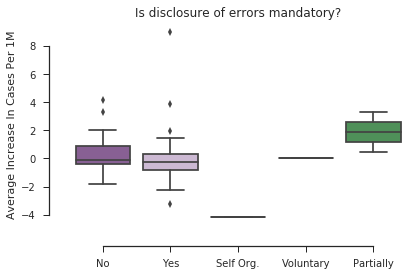

In [53]:
import seaborn as sns
sns.set(style="ticks")

sns.boxplot(x=np.array(ordered_mandatory), 
            y=np.array(df_state_slope_cluster_aslope_acolor["slope"].drop([39])), 
            palette="PRGn", width=0.8)

sns.despine(offset=20, trim=True)
plt.title("Is disclosure of errors mandatory?")
plt.ylabel("Average Increase In Cases Per 1M") #,fontsize=14)
plt.tight_layout()
plt.savefig("Mandatory.png",dpi=300)
plt.show()

## Most problematic license fields:

In [54]:
#data

In [55]:
licnfeld = pd.read_csv('license_fields.csv',delimiter=',')[["Value","Label"]]
licnfeld_dict = licnfeld.to_dict(orient='split')
#np.array(licnfeld_dict['data'])

In [56]:
licnfeld_dict

{'columns': ['Value', 'Label'],
 'data': [[10, 'Allopathic Physician (MD)'],
  [15, 'Physician Resident (MD)'],
  [20, 'Osteopathic Physician (DO)'],
  [25, 'Osteopathic Physician Resident (DO)'],
  [30, 'Dentist'],
  [35, 'Dental Resident'],
  [50, 'Pharmacist'],
  [55, 'Pharmacy Intern '],
  [60, 'Pharmacist, Nuclear'],
  [70, 'Pharmacy Assistant'],
  [75, 'Pharmacy Technician '],
  [76, 'Other Pharmacy Service Occupation'],
  [100, 'Registered Nurse'],
  [110, 'Nurse Anesthetist'],
  [120, 'Nurse Midwife'],
  [130, 'Nurse Practitioner'],
  [134, 'Doctor of Nursing Practice '],
  [135, 'Advanced Nurse Practitioner '],
  [140, 'LPN or Vocational Nurse'],
  [141, 'Clinical Nurse Specialist '],
  [142, 'Other Nurse Occupation'],
  [148, 'Certified Nurse Aide/Nursing Assistant '],
  [150, 'Nurse Aide/Nursing Assistant'],
  [160, 'Home Health Aide (Homemaker)'],
  [165, 'Health Care Aide/Direct Care Worker '],
  [170, 'Psychiatric Technician'],
  [175, 'Certified or Qualified Medication A

In [57]:
dict_fin = {}
for element in licnfeld_dict['data']:
    dict_fin[element[0]] = element[1]

#print(dict_fin)

In [58]:
clustering_data = data.copy()
clustering_data.replace(to_replace= {'LICNFELD': dict_fin}, inplace=True)

In [59]:
clustering_data

,SEQNO,RECTYPE,REPTYPE,ORIGYEAR,WORKSTAT,WORKCTRY,HOMESTAT,HOMECTRY,LICNSTAT,LICNFELD,...,ACCRRPTS,NPMALRPT,NPLICRPT,NPCLPRPT,NPPSMRPT,NPDEARPT,NPEXCRPT,NPGARPT,NPCTMRPT,FUNDPYMT
0,1,A,301,1991,OK,NaN,NaN,NaN,OK,Allopathic Physician (MD),...,0,0,2,0,0,0,0,0,0,NaN
1,2,A,301,1991,OK,NaN,NaN,NaN,OK,Allopathic Physician (MD),...,0,0,7,0,0,0,1,0,0,NaN
2,4,A,301,1991,MA,NaN,NaN,NaN,MA,Physician Resident (MD),...,0,1,1,0,0,0,2,0,0,NaN
3,6,A,301,1990,OK,NaN,NaN,NaN,OK,Allopathic Physician (MD),...,0,0,2,0,0,0,0,0,0,NaN
4,8,A,301,1990,OK,NaN,NaN,NaN,OK,Allopathic Physician (MD),...,0,0,6,0,1,0,0,0,0,NaN
5,9,A,301,1990,OK,NaN,OK,NaN,OK,Allopathic Physician (MD),...,0,1,3,0,0,0,0,0,0,NaN
6,12,A,301,1990,VA,NaN,IL,NaN,VA,Allopathic Physician (MD),...,0,0,10,0,0,0,0,0,0,NaN
7,13,A,301,1990,KY,NaN,KY,NaN,DC,Allopathic Physician (MD),...,0,0,1,0,0,0,0,0,0,NaN
8,14,A,301,1990,OH,NaN,NaN,NaN,OH,Dentist,...,0,0,1,0,0,0,0,0,0,NaN
9,15,A,301,1990,OH,NaN,NaN,NaN,OH,Dentist,...,0,0,3,0,0,0,0,0,0,NaN


clustering_data.hist(column='LICNFELD',alpha=0.5,by='WORKSTAT',figsize=(20,40),layout=(13,5))
plt.xlabel('License')
plt.ylabel('Total Cases')
plt.tight_layout()
plt.savefig('Licenses.png',dpi=300)
plt.show()

plt.figure(figsize=(20,10))
clustering_data['LICNFELD'].hist(bins=xrot=90)
plt.xlabel('License')
plt.ylabel('Total Cases')
plt.tight_layout()
plt.savefig('Licenses.png',dpi=300)
plt.show()

In [60]:
#np.unique(clustering_data['LICNFELD'])

In [61]:
pickle.dump(clustering_data[["LICNFELD","WORKSTAT"]], open("clustering_data.pck", "wb"))

In [62]:
license_state = pickle.load(open("clustering_data.pck", "rb"))

In [63]:
license_state

,LICNFELD,WORKSTAT
0,Allopathic Physician (MD),OK
1,Allopathic Physician (MD),OK
2,Physician Resident (MD),MA
3,Allopathic Physician (MD),OK
4,Allopathic Physician (MD),OK
5,Allopathic Physician (MD),OK
6,Allopathic Physician (MD),VA
7,Allopathic Physician (MD),KY
8,Dentist,OH
9,Dentist,OH


In [171]:
def license_bar_plot(df,upto=20,save=None):
    lic_list = []
    count = []
    for license in np.unique(df['LICNFELD']):
        lic_list.append(license)
        count.append(len(df[df['LICNFELD']==license]))
    lic_count = pd.DataFrame(np.array(count).T,columns=['count'],index=lic_list)
    lic_count.sort_values('count',inplace=True,ascending=False)
    lic_count[:upto].plot(kind='barh',figsize=(20,15),fontsize=24,color=)
    plt.tight_layout()
    if save!=None:
        plt.savefig(save, dpi=300)
    plt.show()
    return lic_count

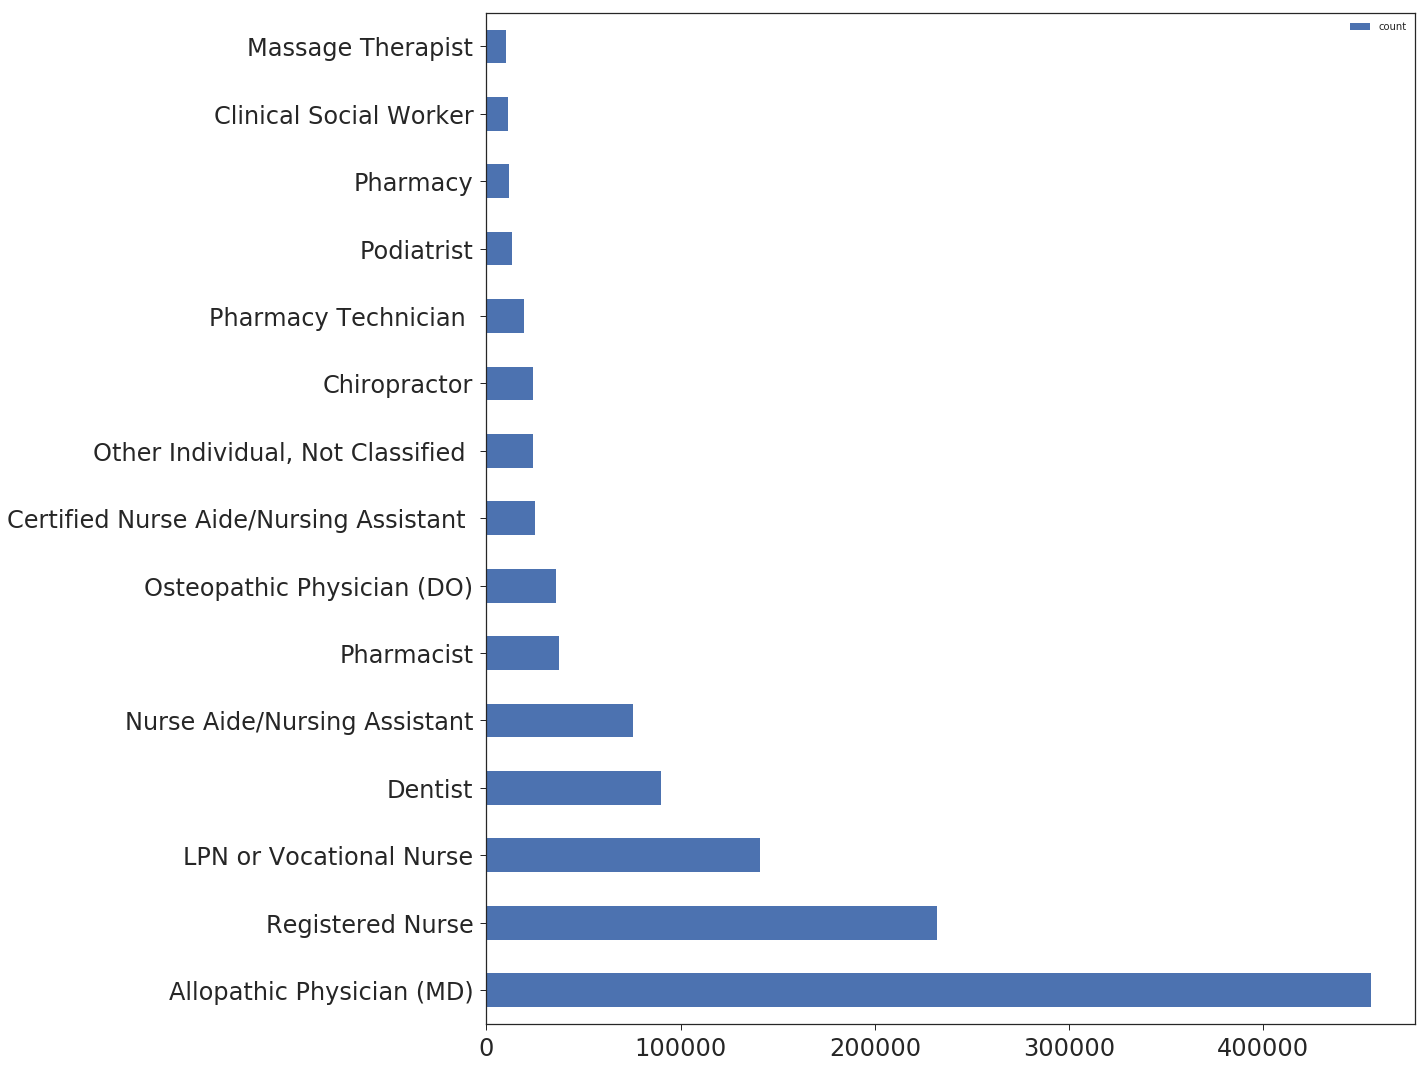

,count
Allopathic Physician (MD),455433
Registered Nurse,231925
LPN or Vocational Nurse,140851
Dentist,89638
Nurse Aide/Nursing Assistant,75341
Pharmacist,37316
Osteopathic Physician (DO),35880
Certified Nurse Aide/Nursing Assistant,25024
"Other Individual, Not Classified",23878
Chiropractor,23819


In [172]:
license_bar_plot(clustering_data,upto=15,save="risky_fields.png")

In [160]:
def license_bar_plot_state(state,upto=10,save=None):
    current = license_state[license_state["WORKSTAT"]==state]
    lic_list = []
    count = []
    for license in np.unique(current['LICNFELD']):
        lic_list.append(license)
        count.append(len(current[current['LICNFELD']==license]))
    lic_count = pd.DataFrame(np.array(count).T,columns=['count'],index=lic_list)
    lic_count.sort_values('count',inplace=True,ascending=False)
    lic_count[:upto].plot(kind='barh',figsize=(20,10),fontsize=20,yticks=lic_list)
    if save!=None:
        plt.savefig(save, dpi=300)
    plt.show()
    return lic_count

In [137]:
bokeh.__version__

u'0.12.16'

In [127]:
from bokeh.charts import Bar, output_file, show
from bokeh.sampledata.autompg import autompg as df

p = Bar(df, label='yr', values='mpg', agg='count',
        title="Average MPG by YR")

output_file("bar.html")

show(p)

ImportError: No module named charts

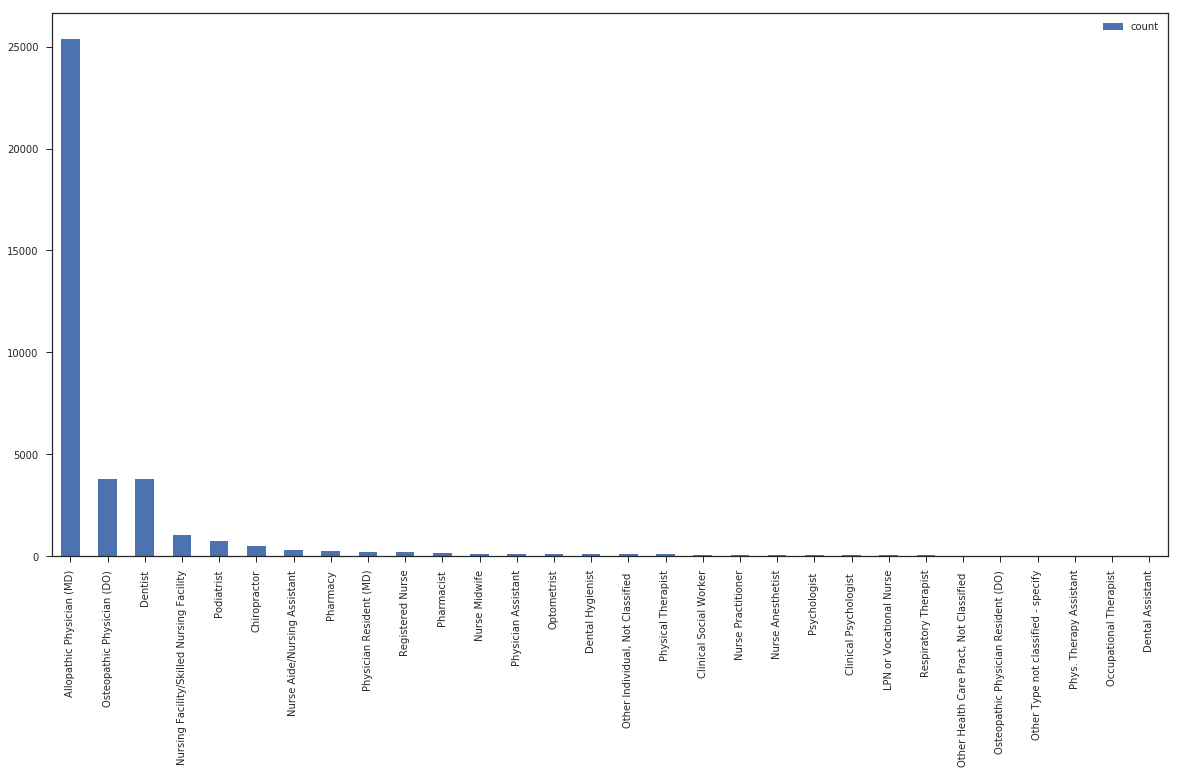

,count
Allopathic Physician (MD),25393
Osteopathic Physician (DO),3806
Dentist,3800
Nursing Facility/Skilled Nursing Facility,1043
Podiatrist,728
Chiropractor,503
Nurse Aide/Nursing Assistant,295
Pharmacy,283
Physician Resident (MD),211
Registered Nurse,190


In [134]:
license_bar_plot_state("PA",upto=30,save="risky_fields_NY.png")

In [68]:
#lic_count_MI = license_bar_plot(clustering_data[clustering_data['WORKSTAT']=="MI"][["LICNFELD","WORKSTAT"]],upto=30)

In [69]:
#lic_count_MI.index

In [70]:
#list(lic_count_MI.index)[:10]

from bokeh.io import output_file, show
from bokeh.sampledata.autompg import autompg as df

p = figure(plot_width=450, plot_height=450)

p.vbar(x=list(lic_count_MI.index)[:10], width=0.5, bottom=0, top=list(lic_count_MI["count"])[:10], color="#CAB2D6")

output_file("bar.html")

show(p)

In [71]:
data.columns

Index([u'SEQNO', u'RECTYPE', u'REPTYPE', u'ORIGYEAR', u'WORKSTAT', u'WORKCTRY',
       u'HOMESTAT', u'HOMECTRY', u'LICNSTAT', u'LICNFELD', u'PRACTAGE',
       u'GRAD', u'ALGNNATR', u'ALEGATN1', u'ALEGATN2', u'OUTCOME', u'MALYEAR1',
       u'MALYEAR2', u'PAYMENT', u'TOTALPMT', u'PAYNUMBR', u'NUMBPRSN',
       u'PAYTYPE', u'PYRRLTNS', u'PTAGE', u'PTGENDER', u'PTTYPE', u'AAYEAR',
       u'AACLASS1', u'AACLASS2', u'AACLASS3', u'AACLASS4', u'AACLASS5',
       u'BASISCD1', u'BASISCD2', u'BASISCD3', u'BASISCD4', u'BASISCD5',
       u'AALENTYP', u'AALENGTH', u'AAEFYEAR', u'AASIGYR', u'TYPE', u'PRACTNUM',
       u'ACCRRPTS', u'NPMALRPT', u'NPLICRPT', u'NPCLPRPT', u'NPPSMRPT',
       u'NPDEARPT', u'NPEXCRPT', u'NPGARPT', u'NPCTMRPT', u'FUNDPYMT'],
      dtype='object')

In [72]:
data[data['HOMECTRY'].notna()]

,SEQNO,RECTYPE,REPTYPE,ORIGYEAR,WORKSTAT,WORKCTRY,HOMESTAT,HOMECTRY,LICNSTAT,LICNFELD,...,ACCRRPTS,NPMALRPT,NPLICRPT,NPCLPRPT,NPPSMRPT,NPDEARPT,NPEXCRPT,NPGARPT,NPCTMRPT,FUNDPYMT


In [73]:
np.nan==np.nan

False

fig, ax1 = plt.subplots(figsize=(14,8))

ax1.bar(range(1990,2018),[len(data[data['ORIGYEAR']==year]) for year in range(1990,2018)],color=current_palette[0])
ax1.set_xlabel('Years',fontsize=30)
ax1.tick_params(axis='x',labelsize=24)
ax1.set_ylabel('Total Number of Malpractice Cases',fontsize=28)
ax1.tick_params(axis='y',labelsize=24,labelcolor=current_palette[0])
ax1.set_ylim(0,100000)

In [74]:
data.columns

Index([u'SEQNO', u'RECTYPE', u'REPTYPE', u'ORIGYEAR', u'WORKSTAT', u'WORKCTRY',
       u'HOMESTAT', u'HOMECTRY', u'LICNSTAT', u'LICNFELD', u'PRACTAGE',
       u'GRAD', u'ALGNNATR', u'ALEGATN1', u'ALEGATN2', u'OUTCOME', u'MALYEAR1',
       u'MALYEAR2', u'PAYMENT', u'TOTALPMT', u'PAYNUMBR', u'NUMBPRSN',
       u'PAYTYPE', u'PYRRLTNS', u'PTAGE', u'PTGENDER', u'PTTYPE', u'AAYEAR',
       u'AACLASS1', u'AACLASS2', u'AACLASS3', u'AACLASS4', u'AACLASS5',
       u'BASISCD1', u'BASISCD2', u'BASISCD3', u'BASISCD4', u'BASISCD5',
       u'AALENTYP', u'AALENGTH', u'AAEFYEAR', u'AASIGYR', u'TYPE', u'PRACTNUM',
       u'ACCRRPTS', u'NPMALRPT', u'NPLICRPT', u'NPCLPRPT', u'NPPSMRPT',
       u'NPDEARPT', u'NPEXCRPT', u'NPGARPT', u'NPCTMRPT', u'FUNDPYMT'],
      dtype='object')

In [75]:
data[["LICNFELD","PRACTAGE","GRAD","PTAGE","PTGENDER","PTTYPE"]]

,LICNFELD,PRACTAGE,GRAD,PTAGE,PTGENDER,PTTYPE
0,10,60.0,1950.0,NaN,NaN,NaN
1,10,40.0,1960.0,NaN,NaN,NaN
2,15,30.0,1980.0,NaN,NaN,NaN
3,10,40.0,1970.0,NaN,NaN,NaN
4,10,40.0,1970.0,NaN,NaN,NaN
5,10,40.0,1970.0,NaN,NaN,NaN
6,10,30.0,1980.0,NaN,NaN,NaN
7,10,70.0,1950.0,NaN,NaN,NaN
8,30,60.0,1950.0,NaN,NaN,NaN
9,30,40.0,1970.0,NaN,NaN,NaN


In [76]:
docs = pd.read_csv('states_MD_vs_DO.csv',header=1)

In [77]:
docs

,Unnamed: 0,Total Population,Number,Rate Per 100000,Rank,Number.1,Rate Per 100000.1,Number.2,Rate Per 100000.2
0,United States,313914040,817850,260.5,NaN,759227,241.9,58409,18.6
1,Alabama,4822023,9681,200.8,44.0,9259,192.0,419,8.7
2,Alaska,731449,1813,247.9,25.0,1642,224.5,171,23.4
3,Arizona,6553255,15133,230.9,32.0,13391,204.3,1738,26.5
4,Arkansas,2949131,5629,190.9,48.0,5377,182.3,252,8.5
5,California,38041430,97977,257.6,20.0,93884,246.8,4063,10.7
6,Colorado,5187582,13869,267.3,16.0,12767,246.1,1098,21.2
7,Connecticut,3590347,11949,332.8,6.0,11527,321.1,420,11.7
8,Delaware,917092,2439,265.9,18.0,2149,234.3,289,31.5
9,District of Columbia,632323,5559,879.1,NaN,5435,859.5,122,19.3


In [78]:
docs_new_index = {}
for new, old in zip(['state','population','totaldocs','docper100000','rank','mds','mdsper100000','dos','dosper100000'],docs.columns):
    docs_new_index[old] = new
    
docs_new_index

{'Number': 'totaldocs',
 'Number.1': 'mds',
 'Number.2': 'dos',
 'Rank': 'rank',
 'Rate Per 100000': 'docper100000',
 'Rate Per 100000.1': 'mdsper100000',
 'Rate Per 100000.2': 'dosper100000',
 'Total Population': 'population',
 'Unnamed: 0': 'state'}

In [79]:
docs.rename(columns=docs_new_index,inplace=True)

In [81]:
state_pop

,Census,Estimates Base,2010,2011,2012,2013,2014,2015,2016,State Abb
United States,308745538,308758105,309348193,311663358,313998379,316204908,318563456,320896618,323127513,US
Northeast,55317240,55318353,55388056,55632766,55829059,55988771,56116791,56184737,56209510,NE
Midwest,66927001,66929825,66978602,67153331,67332320,67543948,67726368,67838387,67941429,MW
South,114555744,114563005,114863114,116061801,117299171,118424320,119696311,121039206,122319574,SO
West,71945553,71946922,72118421,72815460,73537829,74247869,75023986,75834288,76657000,WE
Alabama,4779736,4780131,4785492,4799918,4815960,4829479,4843214,4853875,4863300,AL
Alaska,710231,710249,714031,722713,731089,736879,736705,737709,741894,AK
Arizona,6392017,6392301,6408312,6467163,6549634,6624617,6719993,6817565,6931071,AZ
Arkansas,2915918,2916025,2921995,2939493,2950685,2958663,2966912,2977853,2988248,AR
California,37253956,37254522,37332685,37676861,38011074,38335203,38680810,38993940,39250017,CA


In [82]:
state_pop.loc['Puerto Rico']

Census            3725789
Estimates Base    3726157
2010              3721525
2011              3678732
2012              3634488
2013              3593077
2014              3534874
2015              3473181
2016              3411307
State Abb              PR
Name: Puerto Rico, dtype: object

In [83]:
state_abb =  []
for state in docs['state']:
    if state in state_pop.index:
        state_abb.append(state_pop.loc[state]['State Abb'])
    else:
        state_abb.append(state)

state_abb

['US',
 'AL',
 'AK',
 'AZ',
 'AR',
 'CA',
 'CO',
 'CT',
 'DE',
 'DC',
 'FL',
 'GA',
 'HI',
 'ID',
 'IL',
 'IN',
 'IA',
 'KS',
 'KY',
 'LA',
 'ME',
 'MD',
 'MA',
 'MI',
 'MN',
 'MS',
 'MO',
 'MT',
 'NE',
 'NV',
 'NH',
 'NJ',
 'NM',
 'NY',
 'NC',
 'ND',
 'OH',
 'OK',
 'OR',
 'PA',
 'PR',
 'RI',
 'SC',
 'SD',
 'TN',
 'TX',
 'UT',
 'VT',
 'VA',
 'WA',
 'WV',
 'WI',
 'WY']

In [84]:
docs['state_abb'] = state_abb

In [85]:
docs['ratio'] = docs['mds']/docs['dos']

In [86]:
[df_state_slope_cluster_aslope_acolor['slope']]

[0    -0.203255
 1     2.025211
 2    -0.317074
 3     0.962205
 4    -0.782451
 5    -0.664984
 6    -0.742375
 7    -3.223822
 8    -0.160951
 9    -0.289428
 10   -0.273324
 11   -0.442312
 12   -0.802200
 13    1.251005
 14   -1.446617
 15   -0.774970
 16   -0.851088
 17    0.766673
 18    1.385787
 19   -0.172796
 20    0.315273
 21    1.442024
 22   -4.136127
 23   -0.105733
 24   -0.400788
 25   -0.872224
 26   -1.839958
 27    4.170708
 28    0.191700
 29    0.027153
 30    0.182492
 31    0.197119
 32    0.198316
 33    1.948995
 34   -2.040950
 35   -2.261629
 36    3.287332
 37    3.316135
 38   -2.258678
 39    1.874109
 40   -0.213242
 41    0.690965
 42    0.659559
 43   -0.524569
 44    0.192884
 45    0.286521
 46   -0.118518
 47    3.857940
 48    9.000025
 49   -0.687020
 50   -1.382635
 51    0.476513
 Name: slope, dtype: float64]

In [87]:
df_state_slope_cluster_aslope_acolor[df_state_slope_cluster_aslope_acolor['state']=='IN']['slope']

15   -0.77497
Name: slope, dtype: float64

In [88]:
docs[docs['state_abb']=='IN']['ratio']

15    14.483207
Name: ratio, dtype: float64

In [89]:
df_state_slope_cluster_aslope_acolor

,state,slope,intercept,cluster,avg_slopes,cl_colors
0,AK,-0.203255,464.733599,0,-0.128846,4.0
1,AL,2.025211,-3966.951698,1,1.949438,6.0
2,AR,-0.317074,677.656642,0,-0.128846,4.0
3,AZ,0.962205,-1842.375372,0,-0.128846,4.0
4,CA,-0.782451,1631.942116,0,-0.128846,4.0
5,CO,-0.664984,1395.570399,0,-0.128846,4.0
6,CT,-0.742375,1561.524534,0,-0.128846,4.0
7,DC,-3.223822,6561.454579,2,-3.223822,1.0
8,DE,-0.160951,382.493131,0,-0.128846,4.0
9,FL,-0.289428,647.640492,0,-0.128846,4.0


[-0.2032549808916782, 2.0252105256114876, -0.3170744019562457, 0.9622046389524315, -0.7824514626639071, -0.6649835321924439, -0.7423746089887839, -3.223821800682203, -0.16095083133573143, -0.2894277560172265, -0.2733239005726195, -0.442312159660505, -0.8022004115401459, 1.2510050296568351, -1.446617123060401, -0.7749697070738226, -0.8510880667037141, 0.7666732781642175, 1.3857865955815702, -0.17279556148917585, 0.315273349341463, 1.4420238096315598, -4.13612733949549, -0.10573254688420909, -0.40078819005456146, -0.8722236855561892, -1.8399579079470108, 4.170708190541856, 0.19169966607271335, 0.027152905731637318, 0.1824922505626283, 0.19711910937650545, 0.19831592405552706, 1.9489951321228118, -2.040949884255698, -2.261628696391899, 3.2873316862019974, 3.3161346376434326, -2.258678438317614, 1.8741093642883488, -0.21324231444012662, 0.6909652697226021, 0.659559110961496, -0.5245691208241691, 0.19288356599065185, 0.2865207142713462, -0.1185176239100435, 3.8579395729800625, 9.00002546544

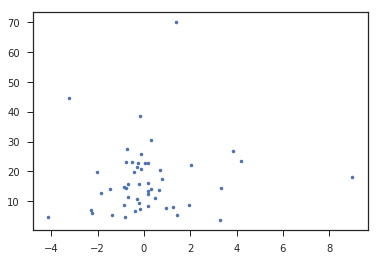

In [90]:
slopes = []
ratios = []
colors = []

for state in common_states:
    #print state
    slopes.append(float(df_state_slope_cluster_aslope_acolor[df_state_slope_cluster_aslope_acolor['state']==state]['slope']))
    ratios.append(float(docs[docs['state_abb']==state]['ratio']))
    colors.append(int(df_state_slope_cluster_aslope_acolor[df_state_slope_cluster_aslope_acolor['state']==state]['cl_colors']))

print slopes
print ratios
plt.plot(slopes,ratios,marker='.',linewidth=0)
plt.show()

In [91]:
pay_count

AK                               AL                    \
       pay_per_case count_per_1000000   pay_per_case count_per_1000000   
1990            NaN          1.347901  166966.666667          4.112434   
1991  196140.625000         41.784945  121558.333333         23.646495   
1992  105808.333333         59.307664  217455.555556         23.440873   
1993  130986.764706         67.395073  230903.448276         26.525199   
1994   85071.428571         59.307664  254741.666667         24.468982   
1995  178137.500000         43.132846  281157.894737         25.497090   
1996  151242.857143         52.568157  405196.236559         25.291469   
1997  158375.000000         36.393339  225808.988764         28.581416   
1998  286718.750000         52.568157  296460.674157         31.871363   
1999  270546.296296         94.353102  274947.887324         30.637633   
2000  159310.344828        172.531386  367873.529412        330.434067   
2001  240925.000000         48.524452  244472.727273        116.998746   
2002  210240.384615         40.437044  233686.781609        137.355294   
2003  241908.333333         57.959762  212584.027778        137.766537   
2004  189822.000000         47.176551  211181.818182        154.421895   
2005  737932.692308         48.524452  223898.305085        163.058006   
2006  187931.818182         44.480748  281934.375000        179.096498   
2007  482916.666667         33.697536  182864.912281        179.918985   
2008  193289.473684         44.480748  310454.545455         67.443917   
2009  229140.625000         40.437044  306960.000000         42.152448   
2010  615511.904762         51.220255  282437.500000        204.593589   
2011  419333.333333         53.916058  250020.833333        190.611313   
2012  361029.411765         49.872354  317812.500000         82.043057   
2013  289482.142857         62.003467  454377.659574         45.236773   
2014  270666.666667         78.178284  637780.172414         41.124339   
2015  334264.705882         60.655565  308533.653846         53.256020   
2016  208750.000000         47.176551  426599.000000         49.966072   
2017  251363.636364         62.003467  402366.071429         56.957210   

                 AR                               AZ                    \
       pay_per_case count_per_1000000   pay_per_case count_per_1000000   
1990   81357.142857          6.023596  166171.250000          6.203947   
1991   83832.258065         39.488021  122601.452282         47.178856   
1992  226307.065217         39.822665  181994.117647         58.143972   
1993  126375.000000         37.145511  111253.600000         57.134027   
1994  116544.871795         32.795136  155957.993197         64.347920   
1995  107418.354430         35.806934  183279.904306         61.029529   
1996  105860.000000         36.476223  134880.930931         79.352816   
1997   96891.791045         35.472290  230950.825083         67.233477   
1998  178015.789474         49.861993  164200.390625         54.248470   
1999  187451.219512         41.495887  182063.586957         69.253366   
2000  225487.654321         80.314619  231539.655172        138.651011   
2001  169092.233010         67.263494  257575.301205        104.745717   
2002  226741.818182         65.590272  254643.769968        102.870105   
2003  326037.974684         71.948513  274889.041096        107.486996   
2004  261940.229885         38.484088  291361.991870        102.148716   
2005  295718.085106         37.480156  273618.580060         91.327877   
2006  213264.492754         33.464425  253462.264151        147.884793   
2007  259293.103448         31.456559  313289.676113        100.994493   
2008  319433.035714         29.448694  327817.073171        104.889995   
2009  330504.098361         36.476223  295964.508929         95.656212   
2010  291380.434783         32.125848  263381.909548         97.387547   
2011  304291.666667         53.208435  311558.849558        114.556610   
2012  252745.833333 

In [92]:
pay_count['AK']['count_per_1000000'].loc[2013]

62.003466802535137

In [93]:
palette

['#00441b',
 '#1b7837',
 '#5aae61',
 '#a6dba0',
 '#d9f0d3',
 '#f7f7f7',
 '#e7d4e8',
 '#c2a5cf',
 '#9970ab',
 '#762a83',
 '#40004b']

In [94]:
plot_colors = [palette[x] for x in colors]

In [95]:
plot_colors

['#d9f0d3',
 '#e7d4e8',
 '#d9f0d3',
 '#d9f0d3',
 '#d9f0d3',
 '#d9f0d3',
 '#d9f0d3',
 '#1b7837',
 '#d9f0d3',
 '#d9f0d3',
 '#d9f0d3',
 '#d9f0d3',
 '#d9f0d3',
 '#f7f7f7',
 '#a6dba0',
 '#d9f0d3',
 '#d9f0d3',
 '#d9f0d3',
 '#f7f7f7',
 '#d9f0d3',
 '#d9f0d3',
 '#f7f7f7',
 '#00441b',
 '#d9f0d3',
 '#d9f0d3',
 '#d9f0d3',
 '#5aae61',
 '#762a83',
 '#d9f0d3',
 '#d9f0d3',
 '#d9f0d3',
 '#d9f0d3',
 '#d9f0d3',
 '#e7d4e8',
 '#5aae61',
 '#5aae61',
 '#c2a5cf',
 '#c2a5cf',
 '#5aae61',
 '#e7d4e8',
 '#d9f0d3',
 '#d9f0d3',
 '#d9f0d3',
 '#d9f0d3',
 '#d9f0d3',
 '#d9f0d3',
 '#d9f0d3',
 '#9970ab',
 '#40004b',
 '#d9f0d3',
 '#a6dba0',
 '#d9f0d3']

In [99]:
output_notebook()

TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,"
plot_s = figure(tools=TOOLS,
           toolbar_sticky=False)

#plot_s.toolbar.toolbar_sticky = False

plot_s.scatter(counts,ratios, radius=0.5,
          fill_color=plot_colors,
          line_color=None)

show(plot_s)

Loading BokehJS ...

[1.3479014522290247, 4.112433944029774, 6.023596435101772, 6.203947413033282, 7.694264183376022, 9.565845959197155, 8.947414924064407, 14.680623045642058, 7.3524391716952096, 7.810817535954867, 4.364537415772914, 2.1000212102142233, 8.294273155297823, 3.564765854296137, 10.233144624251818, 9.497888830377203, 8.94303937448255, 7.888258980106713, 12.815950561189116, 8.367858088173442, 7.479497450904163, 7.51044515159458, 21.65526827352115, 5.978312854894391, 10.3397341211226, 4.684270153905042, 4.7960710585888044, 4.6320076855848376, 9.235413324326606, 0.3736022605427445, 7.491787128360535, 14.198718783641601, 5.2858821296338565, 1.3605173775483341, 16.10510740055514, 14.206535298978258, 8.665597399912988, 6.107295408657458, 15.33139234777355, 0.58628554979074, 6.6261148438224735, 5.039185715964483, 2.310925826213756, 5.562910960047174, 10.121095679670336, 3.6051188755175394, 6.181786365071575, 9.606240213642783, 15.504939626783754, 6.748913424938585, 19.660291999025723, 1.70793901291372

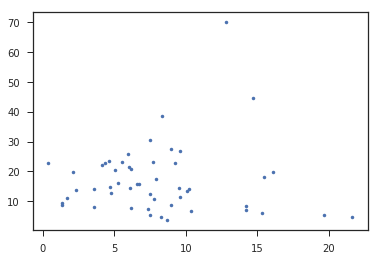

In [100]:
counts = []
ratios = []

for state in common_states:
    #print state
    counts.append(float(pay_count[state]['count_per_1000000'].loc[1990]))
    ratios.append(float(docs[docs['state_abb']==state]['ratio']))

print counts
print ratios
plt.plot(counts,ratios,marker='.',linewidth=0)
plt.show()

In [101]:
docs

,state,population,totaldocs,docper100000,rank,mds,mdsper100000,dos,dosper100000,state_abb,ratio
0,United States,313914040,817850,260.5,NaN,759227,241.9,58409,18.6,US,12.998459
1,Alabama,4822023,9681,200.8,44.0,9259,192.0,419,8.7,AL,22.097852
2,Alaska,731449,1813,247.9,25.0,1642,224.5,171,23.4,AK,9.602339
3,Arizona,6553255,15133,230.9,32.0,13391,204.3,1738,26.5,AZ,7.704833
4,Arkansas,2949131,5629,190.9,48.0,5377,182.3,252,8.5,AR,21.337302
5,California,38041430,97977,257.6,20.0,93884,246.8,4063,10.7,CA,23.107064
6,Colorado,5187582,13869,267.3,16.0,12767,246.1,1098,21.2,CO,11.627505
7,Connecticut,3590347,11949,332.8,6.0,11527,321.1,420,11.7,CT,27.445238
8,Delaware,917092,2439,265.9,18.0,2149,234.3,289,31.5,DE,7.435986
9,District of Columbia,632323,5559,879.1,NaN,5435,859.5,122,19.3,DC,44.549180


In [102]:
docs['mds']/docs['dos']

0     12.998459
1     22.097852
2      9.602339
3      7.704833
4     21.337302
5     23.107064
6     11.627505
7     27.445238
8      7.435986
9     44.549180
10    10.721382
11    22.846585
12    19.809278
13     7.984709
14    14.158013
15    14.483207
16     4.671088
17     8.732595
18    17.397338
19    69.875817
20     5.330233
21    30.497797
22    38.550847
23     4.687581
24    25.880218
25    14.774854
26     6.832394
27    12.921212
28    22.715116
29     8.782847
30    12.408163
31     8.459350
32    16.035211
33    19.737466
34    23.447983
35    22.898551
36     7.142857
37     3.819400
38    14.461322
39     6.159517
40          inf
41    15.876190
42    20.390397
43    13.879032
44    23.320312
45    13.648364
46    14.265789
47    26.786667
48    20.777426
49    18.073651
50     5.575847
51    15.809689
52    10.978261
dtype: float64

In [103]:
pay_count

AK                               AL                    \
       pay_per_case count_per_1000000   pay_per_case count_per_1000000   
1990            NaN          1.347901  166966.666667          4.112434   
1991  196140.625000         41.784945  121558.333333         23.646495   
1992  105808.333333         59.307664  217455.555556         23.440873   
1993  130986.764706         67.395073  230903.448276         26.525199   
1994   85071.428571         59.307664  254741.666667         24.468982   
1995  178137.500000         43.132846  281157.894737         25.497090   
1996  151242.857143         52.568157  405196.236559         25.291469   
1997  158375.000000         36.393339  225808.988764         28.581416   
1998  286718.750000         52.568157  296460.674157         31.871363   
1999  270546.296296         94.353102  274947.887324         30.637633   
2000  159310.344828        172.531386  367873.529412        330.434067   
2001  240925.000000         48.524452  244472.727273        116.998746   
2002  210240.384615         40.437044  233686.781609        137.355294   
2003  241908.333333         57.959762  212584.027778        137.766537   
2004  189822.000000         47.176551  211181.818182        154.421895   
2005  737932.692308         48.524452  223898.305085        163.058006   
2006  187931.818182         44.480748  281934.375000        179.096498   
2007  482916.666667         33.697536  182864.912281        179.918985   
2008  193289.473684         44.480748  310454.545455         67.443917   
2009  229140.625000         40.437044  306960.000000         42.152448   
2010  615511.904762         51.220255  282437.500000        204.593589   
2011  419333.333333         53.916058  250020.833333        190.611313   
2012  361029.411765         49.872354  317812.500000         82.043057   
2013  289482.142857         62.003467  454377.659574         45.236773   
2014  270666.666667         78.178284  637780.172414         41.124339   
2015  334264.705882         60.655565  308533.653846         53.256020   
2016  208750.000000         47.176551  426599.000000         49.966072   
2017  251363.636364         62.003467  402366.071429         56.957210   

                 AR                               AZ                    \
       pay_per_case count_per_1000000   pay_per_case count_per_1000000   
1990   81357.142857          6.023596  166171.250000          6.203947   
1991   83832.258065         39.488021  122601.452282         47.178856   
1992  226307.065217         39.822665  181994.117647         58.143972   
1993  126375.000000         37.145511  111253.600000         57.134027   
1994  116544.871795         32.795136  155957.993197         64.347920   
1995  107418.354430         35.806934  183279.904306         61.029529   
1996  105860.000000         36.476223  134880.930931         79.352816   
1997   96891.791045         35.472290  230950.825083         67.233477   
1998  178015.789474         49.861993  164200.390625         54.248470   
1999  187451.219512         41.495887  182063.586957         69.253366   
2000  225487.654321         80.314619  231539.655172        138.651011   
2001  169092.233010         67.263494  257575.301205        104.745717   
2002  226741.818182         65.590272  254643.769968        102.870105   
2003  326037.974684         71.948513  274889.041096        107.486996   
2004  261940.229885         38.484088  291361.991870        102.148716   
2005  295718.085106         37.480156  273618.580060         91.327877   
2006  213264.492754         33.464425  253462.264151        147.884793   
2007  259293.103448         31.456559  313289.676113        100.994493   
2008  319433.035714         29.448694  327817.073171        104.889995   
2009  330504.098361         36.476223  295964.508929         95.656212   
2010  291380.434783         32.125848  263381.909548         97.387547   
2011  304291.666667         53.208435  311558.849558        114.556610   
2012  252745.833333 

In [104]:
common_states

array(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
       'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
       'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
       'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN',
       'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'],
      dtype='|S3')

In [105]:
pay_count.loc[2013]['AK']['count_per_1000000']

62.003466802535137

In [106]:
state_pop.index[0]

'United States'

In [107]:
state_pop[state_pop['State Abb']=="AZ"].index

Index([u'Arizona'], dtype='object')

In [108]:
docs['state']

0            United States
1                  Alabama
2                   Alaska
3                  Arizona
4                 Arkansas
5               California
6                 Colorado
7              Connecticut
8                 Delaware
9     District of Columbia
10                 Florida
11                 Georgia
12                  Hawaii
13                   Idaho
14                Illinois
15                 Indiana
16                    Iowa
17                  Kansas
18                Kentucky
19               Louisiana
20                   Maine
21                Maryland
22           Massachusetts
23                Michigan
24               Minnesota
25             Mississippi
26                Missouri
27                 Montana
28                Nebraska
29                  Nevada
30           New Hampshire
31              New Jersey
32              New Mexico
33                New York
34          North Carolina
35            North Dakota
36                    Ohio
3

In [109]:
data[["LICNFELD","PRACTAGE","GRAD","PTAGE","PTGENDER","PTTYPE","WORKSTAT"]]

,LICNFELD,PRACTAGE,GRAD,PTAGE,PTGENDER,PTTYPE,WORKSTAT
0,10,60.0,1950.0,NaN,NaN,NaN,OK
1,10,40.0,1960.0,NaN,NaN,NaN,OK
2,15,30.0,1980.0,NaN,NaN,NaN,MA
3,10,40.0,1970.0,NaN,NaN,NaN,OK
4,10,40.0,1970.0,NaN,NaN,NaN,OK
5,10,40.0,1970.0,NaN,NaN,NaN,OK
6,10,30.0,1980.0,NaN,NaN,NaN,VA
7,10,70.0,1950.0,NaN,NaN,NaN,KY
8,30,60.0,1950.0,NaN,NaN,NaN,OH
9,30,40.0,1970.0,NaN,NaN,NaN,OH


In [110]:
pd.__version__

u'0.23.1'

In [111]:
gdp = pd.read_csv('GDP_by_state.csv', header=1, skiprows=3)
gdp.drop(labels=[60,61,62,63,64,65], axis=0,inplace=True)
state_abb2 =  []
for state in gdp['Area']:
    if state in state_pop.index:
        state_abb2.append(state_pop.loc[state]['State Abb'])
    else:
        state_abb2.append(state)

#state_abb2
gdp['state_abb']=state_abb2
gdp

,Fips,Area,1997,1998,1999,2000,2001,2002,2003,2004,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,state_abb
0,00000,United States,8542530.0,9024434.0,9595951.0,10219801.0,10556006.0,10910833.0,11440109.0,12200160.0,...,14320114.0,14859772.0,15406002.0,16041243.0,16576738.0,17312308.0,18007206.0,18509998.0,19263350.0,US
1,01000,Alabama,104218.0,109414.0,115015.0,119020.0,122822.0,127873.0,134388.0,146989.0,...,168315.0,174710.0,180665.0,185878.0,190319.0,193966.0,199804.0,204201.0,210954.0,AL
2,02000,Alaska,25446.0,24030.0,24684.0,26853.0,28553.0,29763.0,32039.0,35195.0,...,50463.0,54134.0,58759.0,60890.0,59808.0,58192.0,52448.0,50542.0,52789.0,AK
3,04000,Arizona,132708.0,143768.0,156145.0,165912.0,172288.0,179605.0,192685.0,204136.0,...,242509.0,245668.0,254192.0,264693.0,270469.0,281069.0,293318.0,304357.0,319850.0,AZ
4,05000,Arkansas,60417.0,62275.0,66715.0,68809.0,70849.0,74097.0,78774.0,85261.0,...,98020.0,102951.0,107287.0,109226.0,114456.0,117953.0,119081.0,121275.0,124918.0,AR
5,06000,California,1081444.0,1151119.0,1248006.0,1362995.0,1376163.0,1431267.0,1523473.0,1645084.0,...,1912115.0,1965886.0,2036297.0,2131199.0,2223892.0,2358920.0,2510167.0,2619639.0,2746873.0,CA
6,08000,Colorado,135868.0,150555.0,164835.0,181488.0,188108.0,193068.0,198811.0,204242.0,...,247270.0,253374.0,262719.0,272799.0,286835.0,305456.0,315621.0,323762.0,342748.0,CO
7,09000,Connecticut,140108.0,147911.0,154708.0,169004.0,175290.0,178017.0,183533.0,200407.0,...,233562.0,234528.0,234233.0,239462.0,240975.0,244612.0,253467.0,257038.0,260827.0,CT
8,10000,Delaware,33672.0,37298.0,41341.0,44851.0,47762.0,46985.0,48949.0,52376.0,...,57350.0,57471.0,59937.0,60628.0,61109.0,66298.0,69893.0,70927.0,73541.0,DE
9,11000,District of Columbia,51566.0,53802.0,57728.0,60059.0,64888.0,69060.0,72780.0,79040.0,...,98415.0,103831.0,107738.0,109685.0,111890.0,116400.0,121688.0,125871.0,131010.0,DC


In [112]:
float(gdp[gdp['state_abb']== 'IN']['2015'])

333436.0

In [113]:
GDP_2013 = []


for state in common_states:
    try:
        print state
        value = float(gdp[gdp['state_abb']== state]['2015'])
        print value
        GDP_2013.append(value)
    except:
        GDP_2013.append(np.nan)
print GDP_2013

AK
52448.0
AL
199804.0
AR
119081.0
AZ
293318.0
CA
2510167.0
CO
315621.0
CT
253467.0
DC
121688.0
DE
69893.0
FL
890884.0
GA
505693.0
HI
81900.0
IA
180511.0
ID
65670.0
IL
778353.0
IN
333436.0
KS
151677.0
KY
190832.0
LA
242059.0
MA
490402.0
MD
365162.0
ME
57242.0
MI
470289.0
MN
326221.0
MO
291764.0
MS
106207.0
MT
46179.0
NC
502077.0
ND
56253.0
NE
116111.0
NH
75162.0
NJ
563616.0
NM
92987.0
NV
142081.0
NY
1458253.0
OH
611350.0
OK
189612.0
OR
215940.0
PA
709722.0
PR
RI
56197.0
SC
202807.0
SD
47231.0
TN
317325.0
TX
1611958.0
UT
149515.0
VA
479669.0
VT
30299.0
WA
453186.0
WI
303826.0
WV
72583.0
WY
39474.0
[52448.0, 199804.0, 119081.0, 293318.0, 2510167.0, 315621.0, 253467.0, 121688.0, 69893.0, 890884.0, 505693.0, 81900.0, 180511.0, 65670.0, 778353.0, 333436.0, 151677.0, 190832.0, 242059.0, 490402.0, 365162.0, 57242.0, 470289.0, 326221.0, 291764.0, 106207.0, 46179.0, 502077.0, 56253.0, 116111.0, 75162.0, 563616.0, 92987.0, 142081.0, 1458253.0, 611350.0, 189612.0, 215940.0, 709722.0, nan, 56197.0

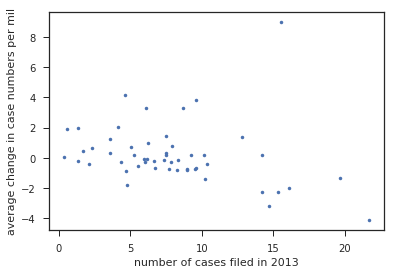

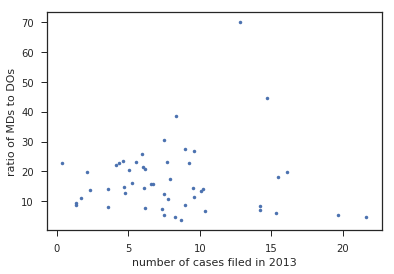

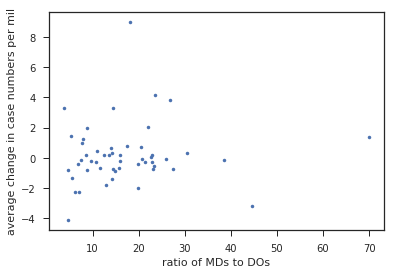

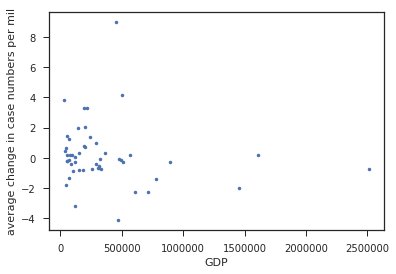

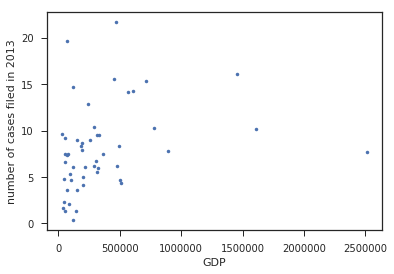

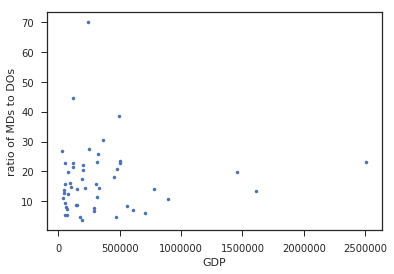

In [114]:
plt.plot(counts,slopes,marker='.',linewidth=0) #, color=plot_colors)
plt.xlabel('number of cases filed in 2013')
plt.ylabel('average change in case numbers per mil')
plt.show()

plt.plot(counts,ratios,marker='.',linewidth=0)
plt.xlabel('number of cases filed in 2013')
plt.ylabel('ratio of MDs to DOs')
plt.show()

plt.plot(ratios,slopes,marker='.',linewidth=0)
plt.xlabel('ratio of MDs to DOs')
plt.ylabel('average change in case numbers per mil')
plt.show()

plt.plot(GDP_2013,slopes,marker='.',linewidth=0)
plt.xlabel('GDP')
plt.ylabel('average change in case numbers per mil')
plt.show()

plt.plot(GDP_2013,counts,marker='.',linewidth=0)
plt.xlabel('GDP')
plt.ylabel('number of cases filed in 2013')
plt.show()

plt.plot(GDP_2013,ratios,marker='.',linewidth=0)
plt.xlabel('GDP')
plt.ylabel('ratio of MDs to DOs')
plt.show()

In [115]:
state_ratings = pd.read_csv('HOSArchive_Revised_Flatfiles_20131001/HCAHPS Measures - State.csv')

In [116]:
for column in state_ratings.columns:
    if 'nurse' in column:
        print column
    if 'doctor' in column:
        print column
    if 'hospital' in column:
        print column

Percent of patients who reported that their nurses 'Sometimes' or 'Never' communicated well.
Percent of patients who reported that their nurses 'Usually' communicated well.
Percent of patients who reported that their nurses 'Always' communicated well.
Percent of patients who reported that their doctors 'Sometimes' or 'Never' communicated well.
Percent of patients who reported that their doctors 'Usually' communicated well.
Percent of patients who reported that their doctors 'Always' communicated well.
Percent of patients at each hospital who reported that YES they were given information about what to do during recovery.
Percent of patients who gave their hospital a rating of 6 or lower on a scale from 0 (lowest) to 10 (highest).
Percent of patients who gave their hospital a rating of 7 or 8 on a scale from 0 (lowest) to 10 (highest).
Patients who gave their hospital a rating of 9 or 10 on a scale from 0 (lowest) to 10 (highest).
Percent of patients who reported NO they would not recomm

state_ratings.rename(index=new_index_list,inplace=True)

In [117]:
hospital_ratings = pd.read_csv('HOSArchive_Revised_Flatfiles_20131001/HCAHPS Measures.csv')

In [118]:
hospital_ratings

,Provider Number,Hospital Name,Address 1,Address 2,Address 3,City,State,ZIP Code,County Name,Phone Number,...,Percent of patients who reported that they were not given information about what to do during their recovery at home.,Percent of patients who gave their hospital a rating of 6 or lower on a scale from 0 (lowest) to 10 (highest).,Percent of patients who gave their hospital a rating of 7 or 8 on a scale from 0 (lowest) to 10 (highest).,Patients who gave their hospital a rating of 9 or 10 on a scale from 0 (lowest) to 10 (highest).,Percent of patients who reported NO they would not recommend the hospital.,Percent of patients who reported YES they would probably recommend the hospital.,Patients who reported YES they would definitely recommend the hospital.,Number of completed Surveys,Survey Response Rate,Hospital Footnote
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,NaN,NaN,DOTHAN,AL,36301,HOUSTON,3347938701,...,14,6,22,72,4,18,78,300 or more,33,NaN
1,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,NaN,NaN,BOAZ,AL,35957,MARSHALL,2565938310,...,12,6,17,77,4,22,74,300 or more,41,NaN
2,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,NaN,NaN,FLORENCE,AL,35631,LAUDERDALE,2567688400,...,23,16,29,55,8,41,51,300 or more,28,NaN
3,10007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,NaN,NaN,OPP,AL,36467,COVINGTON,3344933541,...,24,10,28,62,9,28,63,Between 100 and 299,31,NaN
4,10008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,NaN,NaN,LUVERNE,AL,36049,CRENSHAW,3343353374,...,18,9,25,66,8,29,63,Between 100 and 299,32,NaN
5,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,NaN,NaN,BIRMINGHAM,AL,35235,JEFFERSON,2058383122,...,16,7,21,72,5,21,74,300 or more,34,NaN
6,10012,DEKALB REGIONAL MEDICAL CENTER,200 MED CENTER DRIVE,NaN,NaN,FORT PAYNE,AL,35968,DE KALB,2568453150,...,17,7,25,68,6,31,63,300 or more,31,NaN
7,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,NaN,NaN,ALABASTER,AL,35007,SHELBY,2056208100,...,17,8,21,71,5,23,72,300 or more,29,NaN
8,10018,CALLAHAN EYE HOSPITAL,1720 UNIVERSITY BLVD,NaN,NaN,BIRMINGHAM,AL,35233,JEFFERSON,2053258100,...,16,1,8,91,1,1,98,Fewer than 100,41,Very few patients were eligible for the HCAHPS...
9,10019,HELEN KELLER MEMORIAL HOSPITAL,1300 SOUTH MONTGOMERY AVENUE,NaN,NaN,SHEFFIELD,AL,35660,COLBERT,2563864556,...,13,7,20,73,4,19,77,300 or more,30,NaN


In [119]:
import requests
import dill
from bs4 import BeautifulSoup
from datetime import datetime
import re

In [120]:
def scrape_table(state):
    hospital_info = []
    page = requests.get('https://www.ahd.com/states/hospital_'+state+'.html')
    soup = BeautifulSoup(page.text, "lxml")
    table = soup.select('table')
    table_rows = table[1].find_all('tr')
    for tr in table_rows[:-1]:
        td = tr.find_all('td')
        row = [i.text for i in td]
        hospital_info.append([state]+row)
    return hospital_info

In [121]:
hospital_info = scrape_table('PA')
hospital_df = pd.DataFrame(hospital_info)
hospital_df

KeyboardInterrupt: 